In [ ]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [ ]:
!pip install langchainhub

## Passing Keys for OpenAI, LangChain, LangSmith

In [ ]:
from langchain.tools import BaseTool
from langchain.agents import create_react_agent, Tool
from transformers import BlipProcessor, BlipForConditionalGeneration
from langchain.agents import AgentExecutor, create_react_agent
from langchain_openai import ChatOpenAI
import torch
import openai
openai.api_key=api_key
import jsonschema
from PIL import Image

In [ ]:
import getpass
import os

api_key="sk-proj-9WrNxL8mwGR71Nsg5dlPT3BlbkFJnK22yo3Hw5SraFohJ2DF"
api_langchain="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"
api_langchain2="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"
os.environ['OPENAI_API_KEY']=api_key
os.environ['LANGCHAIN_API_KEY']=api_langchain2
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"
os.environ["TAVILY_API_KEY"] = "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"

## Defining Custom Prompts and System messages for each tool

In [ ]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["ConversationAgent","TextAgent","ImageAgent"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt_supervisor = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        #MessagesPlaceholder(variable_name="agent_scratchpad"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# Define the system prompt for the agent
system_prompt_text_image = (
    "You are an intelligent agent specializing in image analysis. "
    "You will use the provided tool to analyze images and respond to queries about them"
    "You are working in a multi agent environment so collaborate with the other agent as well"
)

# Create the custom prompt template
custom_prompt_image = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_text_image),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)


# Define the system prompt for the agent
system_prompt_text = (
    "You are an intelligent agent specializing in text analysis and responding. "
    "You will use the provided tool to analyze text and respond to queries about them"
    "You are working in a multi agent environment so collaborate with the other agent as well"
)

# Create the custom prompt template
custom_prompt_text = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_text),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# Define the system prompt for the agent
system_prompt_conversation = (
    "You are an intelligent agent specializing in conversation with the user. "
    "You will use the provided tool to analyze text and respond to queries about them"
    "You are working in a multi agent environment so collaborate with the other agent as well"
)

# Create the custom prompt template
custom_prompt_conversation = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_conversation),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

system_prompt_imggen = (
    "You are an intelligent agent specializing in dealing with images that is relevant to the user message or question "
    "You will use the provided tool to analyze text and respond to queries about them"
    "You are working in a multi agent environment so collaborate with the other agent as well"
)


custom_prompt_imggen=ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_imggen),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

## Loading LLM and Creating Supervisor Chain-
supervisor chain in your implementation is designed to manage the workflow of a multi-agent system. It is responsible for directing tasks to the appropriate agent and determining when the workflow is complete

In [ ]:
llm = ChatOpenAI(temperature=0,model="gpt-4-1106-preview")

supervisor_chain = (
    prompt_supervisor
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Creating 4 tools


*   BLIP- Image Vison model
*   Tavily- Search Tool

*   Conversation Tool- Prompt Based ChatGpt
*   ImageGeneration Tool- DallE- OpenAI







## Creating Tool for Image (BLIP Model)

In [ ]:
class BLIP_tool(BaseTool):
  name="Image Analysis Tool"
  description = "Use this tool when given the path to an image that you would like to query" \
                "It will return a response based on the question."

  def _run(self, img_path, input_message):
      image = Image.open(img_path).convert('RGB')

      model_name = "Salesforce/blip-image-captioning-large"
      device = "cuda" if torch.cuda.is_available() else "cpu"

      processor = BlipProcessor.from_pretrained(model_name)
      model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

      inputs = processor(images=image,text=input_message,return_tensors='pt').to(device)
      output = model.generate(**inputs, max_new_tokens=50)

      response = processor.decode(output[0], skip_special_tokens=True)

      return response

In [ ]:
from langchain.agents import AgentExecutor,create_openai_tools_agent
from langchain_core.messages import BaseMessage,HumanMessage
from langchain.agents import Tool, create_react_agent
from langchain.agents import initialize_agent,load_tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain.agents import tool
from langchain_core.callbacks import CallbackManagerForToolRun
from typing import Optional
import requests
import openai
import json
from io import BytesIO

#from tools import BLIP_tool, Seq2Seq_tool

image_tool=BLIP_tool()
tavily_tool = TavilySearchResults()
@tool
def ConversationTool(message:str,run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
  ''' Carries on the discussion and interacts with the user.
    A simple conversational tool that generates a response based on the user's message.
  '''
  return f"Agent: You said '{message}'. How can I assist you further?"

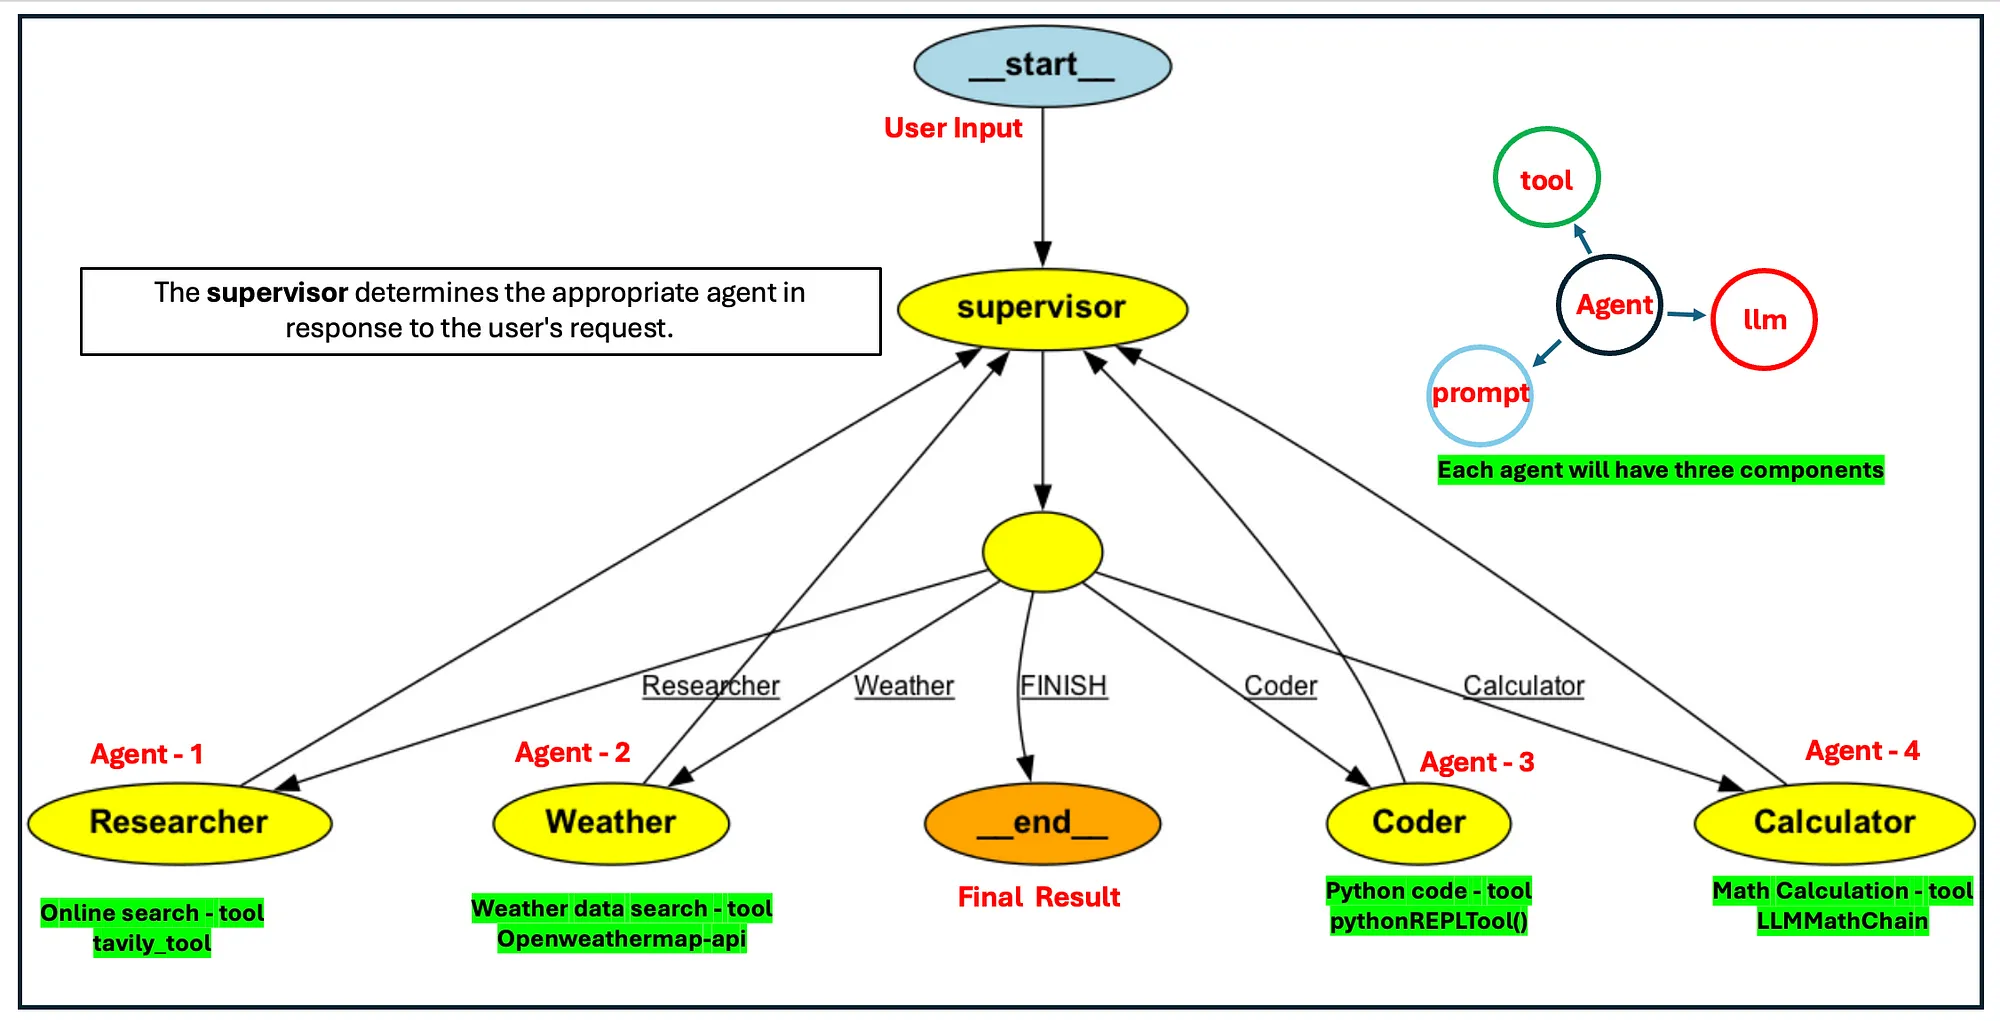

In [ ]:
tools=[image_tool,tavily_tool,ConversationTool]

## Agent created using Tools
### Agent Nodes for LangGraph

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["output"], name=name)],
        #"next": "Supervisor",  # Define logic to determine the next step if needed
        #"intermediate_steps": state.get("intermediate_steps", []) + [result]
    }

In [ ]:
import functools
import operator
from typing import Annotated
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    #intermediate_steps: Annotated[Sequence[dict], operator.add]

In [ ]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain import hub
prompt = hub.pull("hwchase17/react")

In [ ]:
image_agent = create_openai_tools_agent(llm, [image_tool], custom_prompt_image)
# Create an agent executor by passing in the agent and tools
image_agent_executor = AgentExecutor(agent=image_agent, tools=[image_tool], verbose=True)
image_node = functools.partial(agent_node, agent=image_agent_executor, name="ImageAgent")

In [ ]:
text_agent=create_openai_tools_agent(llm,[tavily_tool],custom_prompt_text)
# Create an agent executor by passing in the agent and tools
text_agent_executor = AgentExecutor(agent=text_agent, tools=[tavily_tool], verbose=True)
text_node = functools.partial(agent_node, agent=text_agent_executor, name="TextAgent")

In [ ]:
conv_agent=create_openai_tools_agent(llm,[ConversationTool],custom_prompt_conversation)
# Create an agent executor by passing in the agent and tools
conv_agent_executor = AgentExecutor(agent=conv_agent, tools=[ConversationTool], verbose=True)
conv_node = functools.partial(agent_node, agent=conv_agent_executor, name="ConversationAgent")

## Creating LangGraph Nodes and Workflow

In [ ]:
workflow = StateGraph(AgentState)
workflow.add_node("ImageAgent", image_node)
workflow.add_node("TextAgent", text_node)
workflow.add_node("Supervisor", supervisor_chain)
workflow.add_node("ConversationAgent",conv_node)

In [ ]:
workflow

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "Supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("Supervisor")

graph = workflow.compile()

## Inference currently with no custom JSON Input only message

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Give me recipe of a burger and let us have a conversation")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

{'Supervisor': {'next': 'TextAgent'}}
----


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'burger recipe'}`


[{'url': 'https://tastesbetterfromscratch.com/hamburger-recipe/', 'content': 'Let’s bring the joy back to cooking!\nFollow me for more great recipes\nHealthy Winter Favorites\nRed Curry\nAutumn Butternut Squash and Sweet Potato Soup\nApple Pecan Salad\nTaco Soup\nThai Chicken Lettuce Wraps\nOne-Pan Skinny Chicken Alfredo\nPopular Recipes\nCorn Chowder\nPitaya Bowls\nEdible Cookie Dough\nTruffle Mac and Cheese\nSign Up For FREE Weekly Meal Plans\nEach 5-day meal plan includes a printable grocery shopping list with budget information, to help save time and money!\n Related Posts\nHealthy Dinner Ideas\nAir Fryer Chicken Wings\n15+ Leftover Ham Recipes\nSpatchcock Chicken\nShare Recipe\nOriginal Post June 24, 2020\nUpdated February 3, 2021\nCategories\nLauren Allen\nWelcome! Recipe\nHamburger recipe\nIngredients\xa0\xa01x2x3x\nInstru

In [ ]:
from graphviz import Digraph

# Visualize the graph using Graphviz
def visualize_graph(graph: StateGraph):
    dot = Digraph()

    for node_name, node_data in graph.nodes.items():
        dot.node(node_name, node_name)

    for edge in graph.edges:
        source, destination = edge
        dot.edge(source, destination)

    return dot
dot = visualize_graph(workflow)
dot.render('langgraph_workflow', view=True)

'langgraph_workflow.pdf'